# Queries for OverpassAPI with overpy, shapely and requests

## geolocation by name, get IDnumber

NOTE: Search by area using relation or way id. First lookup OSM id in osm.org. The area id needs to be OSM id + 2400000000 for ways and OSM id + 3600000000 for relations. See https://wiki.osm.org/wiki/Overpass_API/Overpass_QL#By_area_.28area.29


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from geopy.geocoders import Nominatim
import overpy

city_name = "Kreuzberg"

# Geocoding request via Nominatim
geolocator = Nominatim(user_agent="livablestreets")
geo_results = geolocator.geocode(city_name, exactly_one=False, limit=3)

# Searching for relation in result set
for r in geo_results:
    print(r.address, r.raw.get("osm_type"))
    if r.raw.get("osm_type") == "relation":
        city = r
        break


# Calculating area id
area_relid = int(city.raw.get("osm_id")) + 3600000000 #for features
area_wayid = int(city.raw.get("osm_id")) + 2400000000
area_osmid = int(city.raw.get("osm_id")) #for city
print(area_osmid)

Kreuzberg, Friedrichshain-Kreuzberg, Berlin, Deutschland relation
55765


## min max lon lat for city Requests

In [2]:
import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
                [out:json][timeout:25];
                rel({area_osmid});
                out geom;
                """
response = requests.get(overpass_url, 
                            params={'data': overpass_query})
res = response.json()

In [3]:
res['elements'][0]['bounds']

{'minlat': 52.4827923,
 'minlon': 13.3682291,
 'maxlat': 52.5093816,
 'maxlon': 13.4529296}

In [105]:
res

{'version': 0.6,
 'generator': 'Overpass API 0.7.58.2 2b5354b1',
 'osm3s': {'timestamp_osm_base': '2022-06-09T09:18:44Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'relation',
   'id': 5466227,
   'bounds': {'minlat': 29.7483062,
    'minlon': 31.2200331,
    'maxlat': 30.3209168,
    'maxlon': 31.9090054},
   'members': [{'type': 'node',
     'ref': 271613766,
     'role': 'admin_centre',
     'lat': 30.0443879,
     'lon': 31.2357257},
    {'type': 'way',
     'ref': 307284022,
     'role': 'outer',
     'geometry': [{'lat': 30.1979663, 'lon': 31.630124},
      {'lat': 30.1889127, 'lon': 31.6158508},
      {'lat': 30.1721293, 'lon': 31.5924734},
      {'lat': 30.1666484, 'lon': 31.4835106},
      {'lat': 30.1584265, 'lon': 31.4318028},
      {'lat': 30.1581433, 'lon': 31.4264666},
      {'lat': 30.1573987, 'lon': 31.4121895},
      {'lat': 30.1553431, 'lon': 31.3937649},
      {'l

## City boundaries from Shapely

In [4]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize


query = f"""[out:json][timeout:25];
rel({area_osmid});
out body;
>;
out skel qt; """
api = overpy.Overpass()
result = api.query(query)

lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []

    for node in way.nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        geometry.LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
city = geometry.MultiPolygon(polygons)

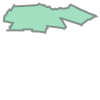

In [5]:
city

### create geojson

In [6]:
from shapely.geometry import mapping
import os 
gjson = mapping(city)

### save geojson

In [10]:
from geojson import Point, Feature, FeatureCollection, dump

working_dir = os.getcwd()
with open(f'{working_dir}/data/{city_name}_boundaries.geojson', 'w') as f:
   dump(mapping(city), f)



## overpass call for features Overpy

In [55]:
# Excecuting overpass call
api = overpy.Overpass()
result = api.query(f"""
    area(%s)->.bound;
    (
      {param_nwr(keys_values_osm)}
    );
    out center;
    """ % area_relid)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))
print("Amenities in areas: %d" % len(result.areas))

OverpassGatewayTimeout: Server load too high

In [ ]:
coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in result.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in result.ways]
coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in result.relations]

In [ ]:
coords

API Reference, test for speeding up, https://python-overpy.readthedocs.io/en/latest/api.html

api = overpy.Overpass()
api.parse_json(data)

overpy.result().parse_json(data)

## test with areas and polygons

In [48]:
water = {'natural': ['water', 'beach'], 'amenity': ['fountain']}

cycle = {'highway': ['pedestrian', 'cycleway']}

green = {
    'landuse': [
        'grass', 'forest', 'orchard', 'allotments', 'cementery', 'flowerbed',
        'meadow', 'greenfield', 'recreation_ground', 'village_green'
    ],
    'leisure': ['park', 'playground', 'garden'],
    'natural': ['heath', 'shrubbery', 'wood', 'grassland']
}


In [11]:
areas_osm = {'leisure': ['park', 'playground', 'garden']}

https://python-overpy.readthedocs.io/en/latest/_modules/overpy.html
execution times

In [15]:
# Excecuting overpass call
from geopandas import GeoDataFrame

api = overpy.Overpass()
s = GeoDataFrame.to_json(gjson)

api.parse_json(s)

result = api.query(f"""
    area(%s)->.bound;
    (
      {param_nwr(areas_osm)}
    );
    out center;
    """ % area_relid)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))
print("Amenities in areas: %d" % len(result.areas))

AttributeError: 'dict' object has no attribute '_to_geo'

In [ ]:
lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []
    nodes = way.get_nodes(resolve_missing=True)
    
    for node in nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        geometry.LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
%time

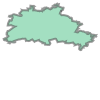

In [49]:
parks

In [34]:
import folium

In [35]:
map_test = folium.Map(width=750,
                      height=500,
                      location=[
                          res['elements'][0]['bounds']['maxlat'],
                          res['elements'][0]['bounds']['maxlon']
                      ],
                      tiles="openstreetmap",
                      zoom_start=15)
folium.GeoJson(mapping(parks)).add_to(map_test)

In [36]:
map_test